In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.


In [ ]:
if not os.path.exists("./gen_pics"):
    os.makedirs(directory)

In [2]:
img_size_cifar = 32
num_channels_cifar = 3 
img_size_flat_cifar = img_size_cifar * img_size_cifar*num_channels_cifar
img_shape_cifar = (img_size_cifar, img_size_cifar, num_channels_cifar)
num_classes_cifar = 10

In [3]:
z_dim = 100

In [4]:
kernel_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)


# define the discriminator
def discriminator(input_images, reuse=False):
    
    with tf.variable_scope('discriminator', reuse= reuse):
        

        
        layer1 = tf.layers.conv2d(input_images, filters=64, 
                                  kernel_size=3, strides=2, 
                                  padding='same', kernel_initializer=kernel_init, name='conv1')

        layer1 = tf.nn.leaky_relu(layer1, alpha=0.2, name='leaky_relu1')
    
        
        layer2 = tf.layers.conv2d(layer1, 
                                  filters=128, 
                                  kernel_size=3, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv2')
        
        layer2 = tf.nn.leaky_relu(layer2, alpha=0.2, name='leaky_relu2')

        layer3 = tf.layers.conv2d(layer2, 
                                  filters=128, 
                                  kernel_size=3, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv3')
        
        layer3 = tf.nn.leaky_relu(layer3, alpha=0.2, name='leaky_relu3')
 


        layer4 = tf.layers.conv2d(layer3, 
                                 filters=256, 
                                 kernel_size=3, 
                                 strides=2,
                                 padding='same',
                                 name='conv4')
        # layer3 = tf.layers.batch_normalization(layer3,momentum=0.99, training=is_training, name='batch_normalization3')
        layer4 = tf.nn.leaky_relu(layer4, alpha=0.2, name='leaky_relu4')
        
        
        layer4 = tf.layers.flatten(layer4)
        # layer4 = tf.reshape(layer4, (-1, layer4.shape[1]*layer4.shape[2]*layer4.shape[3]))
        layer4 = tf.nn.dropout(layer4, keep_prob=0.6)
        
        logits_discrim= tf.layers.dense(layer4, 1)
        
        output_discrim = tf.sigmoid(logits_discrim)
        
        
        # build the aux layer
        net_1 = tf.layers.dense(inputs=layer4, name='aux_fc1', units=128, activation=tf.nn.relu)
        logits_label = tf.layers.dense(inputs=net_1, name='aux_fc_out', units=num_classes_cifar, activation=None)
        output_label_one_hot = tf.nn.softmax(logits=logits_label)
        output_label_s = tf.argmax(output_label_one_hot, dimension=1)
        
        return logits_discrim, logits_label, output_label_s
    
    
# define generator 

def generator(z, fake_label, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        

        input_to_conv = tf.layers.dense(tf.concat([z, fake_label], axis=1), 4*4*512)
        

        layer1 = tf.reshape(input_to_conv, (-1, 4, 4, 512))
        layer1 = tf.nn.leaky_relu(layer1, alpha=0.2, name='leaky_relu1_g')
        
        
        layer2 = tf.layers.conv2d_transpose(layer1, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution2')
        layer2 = tf.nn.leaky_relu(layer2, alpha=0.2, name='leaky_relu2_g')
        
 
        layer3 = tf.layers.conv2d_transpose(layer2, filters=128, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution3')
        
        
        layer3 = tf.nn.leaky_relu(layer3, alpha=0.2, name='leaky_relu3_g')
        

        layer4 = tf.layers.conv2d_transpose(layer3, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution4')
        
        layer4 = tf.nn.leaky_relu(layer4, alpha=0.2, name='leaky_relu4_g')
        
        

        layer5 = tf.layers.conv2d_transpose(layer4, filters=3, kernel_size=5, strides=1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution5')
           
        
        logits = tf.tanh(layer5, name='tanh')
        
        return logits
    
    
x = tf.placeholder(tf.float32, shape= (None, img_size_cifar, img_size_cifar, num_channels_cifar), name="d_input")
label_true = tf.placeholder(tf.float32, [None, num_classes_cifar], name="label_true")

z = tf.placeholder(tf.float32, shape= (None, z_dim), name="z_noise")
label_fake = tf.placeholder(tf.float32, shape= (None, num_classes_cifar), name="label_fake")

is_training = tf.placeholder(tf.bool, [], name='is_training')



fake_x=generator(z, label_fake)

D_logit_real_discrim, D_logit_real_label, D_output_real_label = discriminator(x, reuse=False)

D_logit_fake_discrim, D_logit_fake_label, D_output_real_label = discriminator(fake_x, reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use the `axis` argument instead


In [5]:
saver = tf.train.Saver()

In [6]:
def get_fake_labels(num_labels):
    fake_label_value = np.random.randint(num_classes_cifar, size=num_labels)
    fake_label_value = fake_label_value.reshape(-1,1)
    # print(fake_label_value)
    fake_label_value = to_categorical(fake_label_value, num_classes_cifar)
    return fake_label_value

In [7]:
cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def get_label(test_num_list_one_hot):
    test_label_list = []
    for test_num_one_hot in test_num_list_one_hot:
        index_1 = np.argmax(test_num_one_hot)
        test_label_list.append(cls_names[index_1])
    return test_label_list

In [8]:
def show_the_plots_labels(pic_list, label_list):
    len_1 = len(pic_list)
    width_1 = int(np.ceil(np.sqrt(len_1)))
    fig, axes = plt.subplots(width_1, width_1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    labels_description = get_label(label_list)
    for i in range(len_1):
        axes.flat[i].imshow((pic_list[i]+1)/2)
        axes.flat[i].set_xlabel(labels_description[i])
        axes.flat[i].set_xticks([])
        axes.flat[i].set_yticks([])
    plt.savefig("ACGAN_example.jpg") 
    plt.show()

In [9]:
def show_the_plots_labels_10(pic_list, label_list):
    len_1 = len(pic_list)
    # width_1 = int(np.ceil(np.sqrt(len_1)))
    fig, axes = plt.subplots(2, 5)
    #fig.subplots_adjust(hspace=0.3, wspace=0.3)
    labels_description = get_label(label_list)
    for i in range(len_1):
        axes.flat[i].imshow((pic_list[i]+1)/2)
        axes.flat[i].set_xlabel(labels_description[i])
        axes.flat[i].set_xticks([])
        axes.flat[i].set_yticks([])
    plt.savefig("ACGAN_example.jpg") 
    plt.show()

In [10]:
def generate_new_samples_with_labels(session, num_plots):
    
    #randomly sample noise from the normal distribution
    z = np.random.normal(0.0, 1.0, size=[num_plots, z_dim]).astype(np.float32)
    print(np.shape(z))

    is_training = tf.placeholder(tf.bool, [], name='training_bool')     
    #generate a fake image
    
    fake_label_s = get_fake_labels(num_plots)
    print(np.shape(fake_label_s))
    samples = session.run(generator(z,fake_label_s, reuse=True))
    show_the_plots_labels(samples, fake_label_s)

In [11]:
def generate_new_samples_with_labels_10(session, num_plots):
    
    #randomly sample noise from the normal distribution
    z = np.random.normal(0.0, 1.0, size=[num_plots, z_dim]).astype(np.float32)
    print(np.shape(z))

    is_training = tf.placeholder(tf.bool, [], name='training_bool')     
    #generate a fake image
    
    fake_label_s = get_fake_labels(num_plots)
    print(np.shape(fake_label_s))
    samples = session.run(generator(z,fake_label_s, reuse=True))
    show_the_plots_labels_10(samples, fake_label_s)

In [12]:
def save_image(data, filename):
    sizes = np.shape(data)     
    fig = plt.figure()
    fig.set_size_inches(1. * sizes[0] / sizes[1], 1, forward = False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    plt.savefig(filename, dpi = sizes[0]) 
    plt.close()
    
def save_pics(pic_list):
    i = 0
    for pic in pic_list:
        i += 1
        image_data = (pic+1)/2
        save_image(image_data, "gen_pics/DCGAN_pic_{}.jpg".format(i))
        
def save_new_samples(session, num_plots):
    
    #randomly sample noise from the normal distribution
    z = np.random.uniform(-1,1, size=[num_plots, z_dim]).astype(np.float32)

    is_training = tf.placeholder(tf.bool, [], name='training_bool')     
    fake_label_s = get_fake_labels(num_plots)
    
    
    samples = session.run(generator(z, fake_label_s, reuse=True))
    save_pics(samples)

INFO:tensorflow:Restoring parameters from ./saved_models/model_backup.ckpt
(10, 100)
(10, 10)


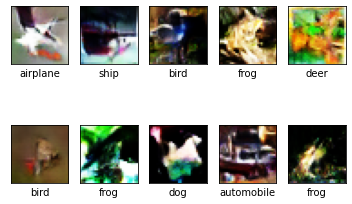

In [25]:
with tf.Session() as sess_1:
    saver.restore(sess_1, "./saved_models/model_backup.ckpt") 
    generate_new_samples_with_labels_10(sess_1, 10)
    save_new_samples(sess_1, 2560)